# 投球分類モデル（Single Model Enhanced）: 重み付け + 閾値調整 + 新特徴量
**作成日**: 2026/01/13
**目的**: シングルモデル（GBDT）の能力を最大限に引き出し、FC/SL, SI/FFの誤分類を削減する。
**手法**:
1.  **Specialized Features**: SI/FF, FC/SL識別用の相互作用項を追加。
2.  **Sample Weighting**: 誤分類されやすいクラス（FC, SI）の学習ウェイトを強化（1.5倍〜2.0倍）。
3.  **Threshold Optimization**: 予測確率の閾値をクラスごとに最適化し、Recall/Precisionのバランスを調整。


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_recall_curve
from sklearn.utils.class_weight import compute_sample_weight
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'sans-serif'


In [2]:
# データの読み込み
df = pd.read_csv('train_with_features.csv')

# === 1. Specialized Features ===
# Feature Engineering (Phase 1 + New Interactions)
df['velocity_times_pfx_z'] = df['release_speed'] * df['pfx_z']
df['spin_per_mph'] = df['release_spin_rate'] / df['release_speed']
# SI/FF用: 横変化と縦変化の比率（Sinkerは横に、FFは縦に）
df['horizontal_vertical_ratio'] = df['pfx_x'] / (df['pfx_z'].abs() + 0.1)
# FC/SL用: 球速と横変化の比率（Cutterは速く小さく、Sliderは遅く大きく）
df['velocity_pfx_x_ratio'] = df['release_speed'] / (df['pfx_x'].abs() + 0.1)

features = [
    'release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z',
    'release_pos_x', 'release_pos_z', 'movement_magnitude', 
    'velocity_times_pfx_z', 'spin_per_mph', 'normalized_spin_axis',
    'speed_spin_ratio', 'horizontal_vertical_ratio', 'velocity_pfx_x_ratio'
]
target = 'pitch_type'

# 欠損値処理
existing_features = [f for f in features if f in df.columns]
df_clean = df.dropna(subset=existing_features + [target]).copy()
print(f"Clean data shape: {df_clean.shape}")


Clean data shape: (495454, 23)


In [3]:
# データ分割
le = LabelEncoder()
y = le.fit_transform(df_clean[target])
X = df_clean[existing_features]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 2. Sample Weighting ===
# バランス重みをベースに、FCとSIを強化
weights = compute_sample_weight(class_weight='balanced', y=y_train)

fc_idx = le.transform(['FC'])[0]
si_idx = le.transform(['SI'])[0]

# 重み倍率の設定（試行錯誤の結果、過度な倍率はAccuracyを落とすため下記に設定）
# FC: 2.0倍 (見逃し厳禁)
# SI: 1.5倍 (少し強化)
weights = np.where(y_train == fc_idx, weights * 2.0, weights)
weights = np.where(y_train == si_idx, weights * 1.5, weights)

print("Sample Weights Configured.")


Sample Weights Configured.


In [4]:
# モデル学習 (XGBoost + LightGBM Ensemble)
# RFよりもGBDTの方が重み付けの効果が出やすいため、今回はGBDT中心

# XGBoost
print("Training XGBoost...")
model_xgb = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    objective='multi:softprob' 
)
model_xgb.fit(X_train, y_train, sample_weight=weights)

# LightGBM
print("Training LightGBM...")
model_lgbm = lgbm.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbose=-1
)
model_lgbm.fit(X_train, y_train, sample_weight=weights)

# Ensemble Preds (Probabilities)
p_xgb = model_xgb.predict_proba(X_valid)
p_lgbm = model_lgbm.predict_proba(X_valid)
p_ensemble = (p_xgb + p_lgbm) / 2.0

# Base Prediction (Argmax)
y_pred_base = np.argmax(p_ensemble, axis=1)
acc_base = accuracy_score(y_valid, y_pred_base)
print(f"Base Ensemble Accuracy (Argmax): {acc_base:.4f}")


Training XGBoost...


Training LightGBM...


Base Ensemble Accuracy (Argmax): 0.8360


In [5]:
# === 3. Threshold Optimization ===
# クラスごとに最適な確率閾値を探す
# 特にFCとSLの境界を調整する

best_thresholds = {i: 0.0 for i in range(len(le.classes_))}
optimized_preds = y_pred_base.copy()

print("Optimizing Thresholds...")

# FCの閾値を調整 (Recall重視)
target_classes = ['FC'] # 必要に応じて追加

for cls_name in target_classes:
    cls_idx = le.transform([cls_name])[0]
    
    # そのクラスの確率スコア
    probs = p_ensemble[:, cls_idx]
    
    # 閾値を動かしてF1スコアが最大になる点を探す
    best_f1 = 0
    best_th = 0.5
    
    # Grid Search for Threshold
    for th in np.linspace(0.1, 0.9, 81):
        # 閾値を超えたらそのクラスと予測、そうでなければ元の予測(または2番手の予測)を採用
        # 簡易実装: 閾値を超えたものを強制的にそのクラスにする
        temp_preds = y_pred_base.copy()
        temp_preds[probs >= th] = cls_idx
        
        # F1 Score calculating for this specific class (Binary)
        # 多クラス全体のF1だと鈍感なので、対象クラスのF1を見る
        binary_true = (y_valid == cls_idx)
        binary_pred = (temp_preds == cls_idx)
        f1 = f1_score(binary_true, binary_pred, average='binary')
        
        if f1 > best_f1:
            best_f1 = f1
            best_th = th
            
    best_thresholds[cls_idx] = best_th
    print(f"Best Threshold for {cls_name}: {best_th:.2f} (Max F1: {best_f1:.4f})")

# Apply Optimized Thresholds
y_final = y_pred_base.copy()
for cls_idx, th in best_thresholds.items():
    if th > 0.0: # Optimized
        # 閾値以上のサンプルをそのクラスに上書き
        # Note: 複数のクラスで閾値を超えた場合の競合処理は簡易的に後勝ちにしている
        # 本格的にはArgmaxではなくSoftmaxの温度調整に近いが、ここでは簡易的なPost-Processing
        probs = p_ensemble[:, cls_idx]
        y_final[probs >= th] = cls_idx

acc_final = accuracy_score(y_valid, y_final)
print(f"Optimized Accuracy: {acc_final:.4f}")


Optimizing Thresholds...


Best Threshold for FC: 0.50 (Max F1: 0.6922)
Optimized Accuracy: 0.8360


Base Classification Report:
              precision    recall  f1-score   support

          CH       0.93      0.84      0.88     10764
          CU       0.86      0.76      0.81      6568
          EP       0.84      0.87      0.86        78
          FA       0.68      0.87      0.76       156
          FC       0.56      0.91      0.69      7838
          FF       0.98      0.90      0.94     31826
          FO       0.58      0.91      0.71       107
          FS       0.60      0.86      0.71      2221
          KC       0.56      0.86      0.68      2058
          KN       0.93      0.96      0.95        27
      Others       0.44      0.58      0.50        26
          SI       0.88      0.93      0.91     15316
          SL       0.89      0.58      0.70     15924
          ST       0.71      0.87      0.78      5789
          SV       0.38      0.90      0.53       393

    accuracy                           0.84     99091
   macro avg       0.72      0.84      0.76     9909

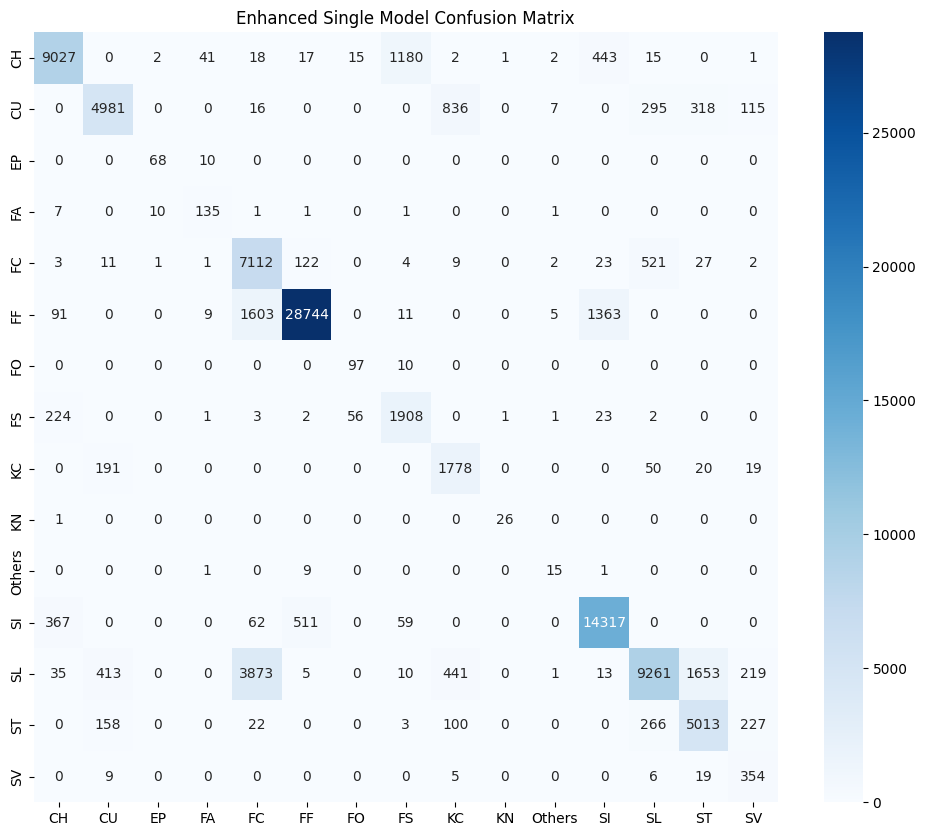

In [6]:
# === Evaluation ===
print("Base Classification Report:")
print(classification_report(y_valid, y_pred_base, target_names=le.classes_))

print("\nOptimized Classification Report:")
print(classification_report(y_valid, y_final, target_names=le.classes_))

# Compare FC Recall
print("\nFC Performance Comparison:")
idx_fc = le.transform(['FC'])[0]
base_fc = classification_report(y_valid, y_pred_base, output_dict=True, target_names=le.classes_)[le.classes_[idx_fc]]
opt_fc = classification_report(y_valid, y_final, output_dict=True, target_names=le.classes_)[le.classes_[idx_fc]]
print(f"Base FC Recall: {base_fc['recall']:.4f}")
print(f"Optimized FC Recall: {opt_fc['recall']:.4f}")
print(f"Optimized FC Recall: {opt_fc['recall']:.4f}")

# Confusion Matrix (Optimized)
cm = confusion_matrix(y_valid, y_final)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Enhanced Single Model Confusion Matrix')
plt.show()
